In [1]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
mount='/content/gdrive'
root_path = mount + "/My Drive/LaneNet/"
%cd $root_path
%pwd

/content/gdrive/My Drive/LaneNet


'/content/gdrive/My Drive/LaneNet'

In [3]:
!ls

Test_set  Train_set


#DATASET HAZIRLAMA

JSONDAN SEGMENTASYON MASKESI HAZIRLAMA

In [8]:
import json
import os
import numpy as np
import PIL.Image
import cv2
import matplotlib.pyplot as plt
import glob
from pathlib import Path


In [17]:
def read_images_and_data(data,files_in_directory):
  img=[]#görselleri matris halinde tutacak array
  lanes=[] #görsellerde bulunan şeritlerin x koordinatlarını tutan liste [[..],[..],[..]] 3 adet şerit bilgisi var 
  h_samples=[] #şeritlerin y bilgisi

  for  j in range(len(data)):
    image_name=dict(data[j])['raw_file'] #jsondan image path bilgilerini çek
  #Eğer json datası içerisinde aldığımız görseller mevcut ise cv2 ile içeri aktar
    if image_name in files_in_directory: 
      img_=cv2.imread(root+"/"+image_name)
      img.append(img_)      
    else:
        continue
    lanes.append(data[j]['lanes'])
    h_samples.append(data[j]['h_samples'])
  return img,lanes,h_samples


In [13]:
def get_all_files(path):
  files_in_directory=[]
  for root, dirs, files in os.walk(path):
    root=root.split('Train_set/')[1]
    for filename in files:
        files_in_directory.append(root+'/'+filename)
  return files_in_directory

Oluşturulacak maskelerin kaydedileceği 'masked_image' klasörünün oluşturulması




In [42]:
def creating_segmentation_mask(img,lanes,h_samples,file_base_name):

  path=os.path.join(segmentated_images,file_base_name)
  os.mkdir(path)
  for i,lanes in enumerate(lanes):
    mask=np.zeros((img[i].shape[0],img[i].shape[1]),dtype=np.float32)
    for lane in lanes:
      for j,markings in enumerate(lane):
        #bazı şerit bilgileri boş -2 olarak girilmiş.-2 olmayan değerleri ve buna karşılık gelen h değerlerini alıp listeye atıyoruz
        if markings !=-2 :
          #fig = plt.figure()
          mask=cv2.circle(mask,(markings,h_samples[i][j]),1, (255,255,255),20)
          #plt.imshow(mask)
        else:
          continue
 
    cv2.imwrite(path+'/%05.0f' % i +'.png',mask.astype(np.uint8))    



**segmentasyon maskesini oluşturulması ve klasöre kaydedilmesi**

In [43]:
root="/content/gdrive/MyDrive/LaneNet/Train_set"
directory="segmentation_mask"
segmentated_images=os.path.join(root,directory)
os.mkdir(segmentated_images)
dicts_=glob.glob(root+"/*json")
clips_dict_list=glob.glob(root+"/"+"clips/*")


file_base_name=[]
json_base_name=[]

for clips in clips_dict_list:
  file_base_name=Path(clips).stem
  print(file_base_name)
  for dicts in dicts_:
    json_base_name=(Path(dicts).stem.split("_")[-1])

    if json_base_name ==file_base_name:
        files_list=get_all_files(clips)
        data = [json.loads(line) for line in open(dicts, 'r')]
  img,lanes,h_samples=read_images_and_data(data,files_list)

  creating_segmentation_mask(img,lanes,h_samples,file_base_name)




0601
0531


Örnek bir görsel ve karşılık gelen maskenin çizilmesi
---



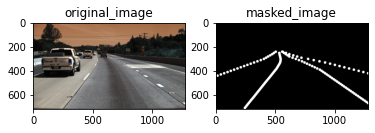

In [57]:
mask=cv2.imread(segmentated_images+'/0531/00000.png',cv2.IMREAD_GRAYSCALE)
plt.figure()
plt.subplot(1,2,1)
plt.title("original_image")
plt.imshow(img[0])
plt.subplot(1,2,2)
plt.title("masked_image")
plt.imshow(mask,cmap="gray")


#U-NET MODAL

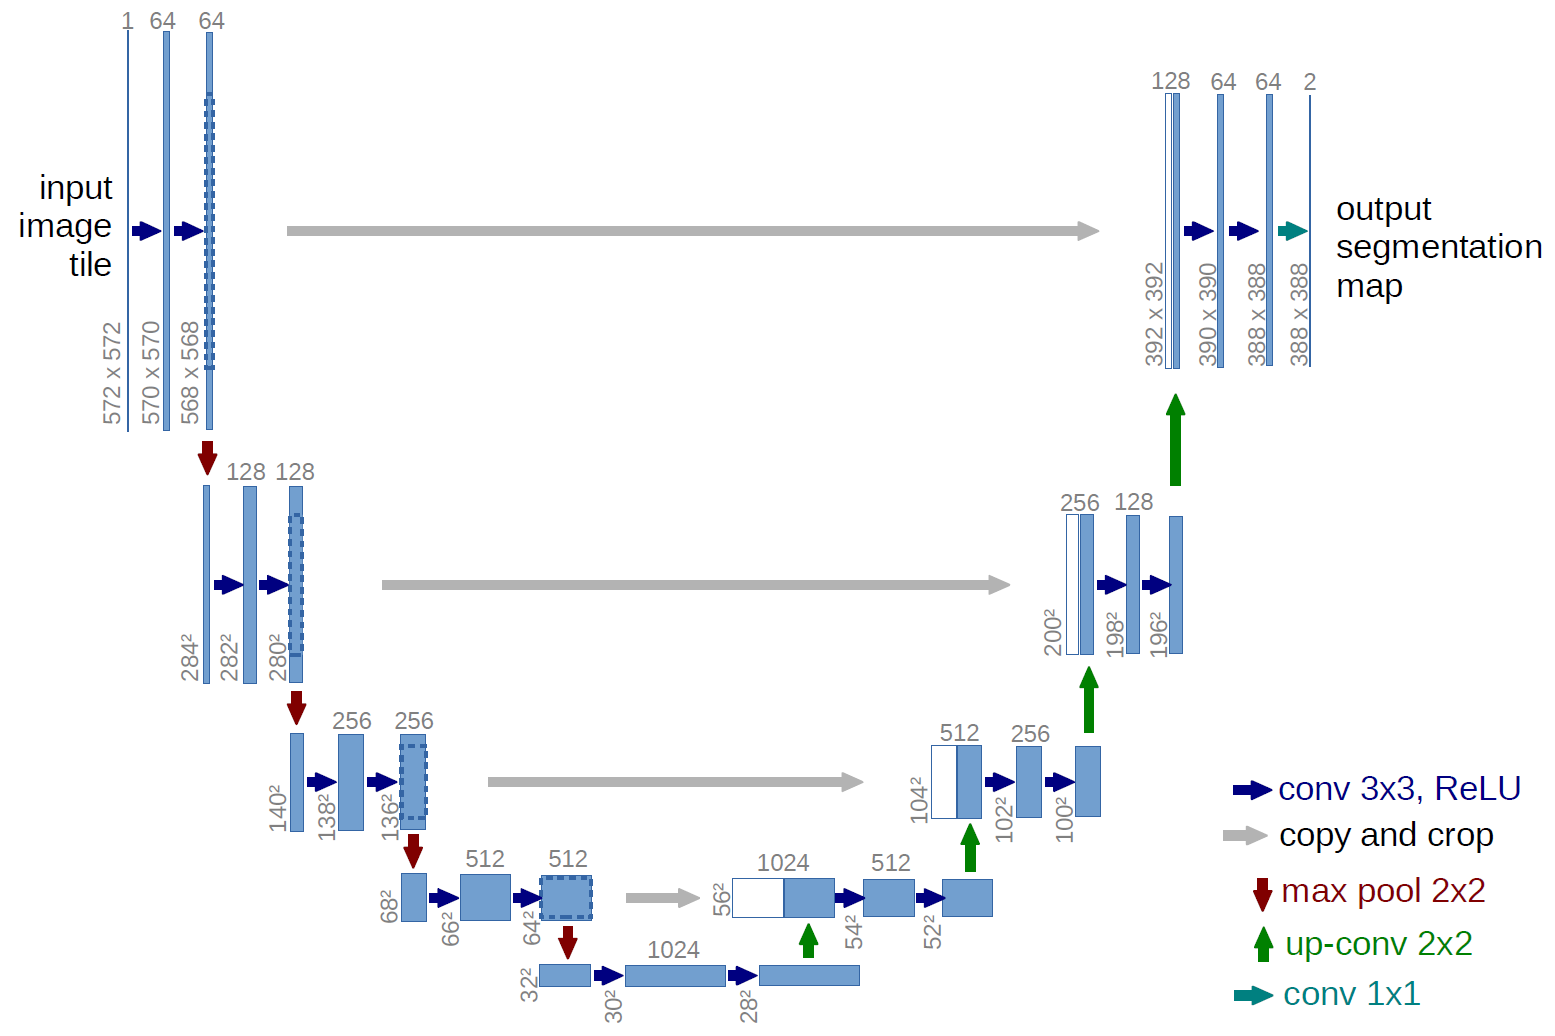

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix

from IPython.display import clear_output
import matplotlib.pyplot as plt

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# feature extraction modeli oluştur
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

In [ ]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [ ]:
def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)